# GeoTif Training
- Pick index for tring
- Convert the nasa data to lable tif

## Pending Issue:
- coarser  points data 375m than the nicfi 5meter
- If dropping the points data outside the target area, may lost something correct data if not dropping the data, model will be biased learning from the building area, it's Inaccurate, may overfitting based on the more noise data.
- Current plan is to drop the points data outside the target area, and then clip the points data to the target area. also have buffer area to get 100 meter area of the dumpsite.

## Preparing the data 
- target index list
- check the data count for each index
- check the shapefile
- show the nasa points on map



In [12]:
index_list=[581,1806,1212,1189,438,489,782]

import os

# Get the current working directory
base_dir = os.getcwd()

# Define paths using the base directory
tif_folder_path = os.path.join(base_dir, 'tif')
tif_label_folder_path = os.path.join(base_dir, 'tif_label')
J1V_shapefile_path = os.path.join(base_dir, 'nasa_data', 'J1V_Clip', 'fire_nrt_J1VC2_536460_clip.shp')
target_dp_shapefile_path = os.path.join(base_dir, 'Target_DP_shape','c1212_ADRSM_T.shp')

In [4]:
import os

def check_tif_data(index_list,tif_path):
    # count the tif file number for files start with index
    for index in index_list:
        tif_file_list=os.listdir(tif_path)
        tif_file_list=[file for file in tif_file_list if file.startswith(str(index))]
        print(f'index {index} has {len(tif_file_list)} tif files')

check_tif_data(index_list,tif_folder_path)


index 581 has 42 tif files
index 1806 has 42 tif files
index 1212 has 42 tif files
index 1189 has 42 tif files
index 438 has 42 tif files
index 489 has 42 tif files
index 782 has 42 tif files


### Helper Function

In [3]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import leafmap
import geopandas as gpd

def show_tif_image_rgb(source_type, file_path):
    if source_type == 'nicfi':
        # read the tif file
        tif_file = rasterio.open(file_path)
        
        # read RGB bands
        blue = tif_file.read(1).astype(float)
        green = tif_file.read(2).astype(float)
        red = tif_file.read(3).astype(float)
        
        def normalize_nicfi(band):
            # Clip values to GEE visualization range
            band = np.clip(band, 64, 5454)  # Match GEE min/max values
            # Normalize to 0-1 range based on the visualization parameters
            band = (band - 64) / (5454 - 64)
            return band
        
        red = normalize_nicfi(red)
        green = normalize_nicfi(green)
        blue = normalize_nicfi(blue)
        
        # stack bands into RGB image
        rgb = np.dstack((red, green, blue))
        
        # Apply gamma correction matching GEE
        gamma = 1.8  # Same gamma as GEE
        rgb = np.power(rgb, 1/gamma)
        
        # get filename for title
        title = os.path.basename(file_path)
        
        # display image
        plt.figure(figsize=(4,4))
        plt.imshow(rgb)
        plt.title(title)
        plt.axis('off')
        plt.show()


def display_shapefile_on_map(shapefile_path):
    """
    Loads a shapefile and displays it on an interactive map.

    Parameters:
    shapefile_path (str): The file path to the shapefile.

    Returns:
    leafmap.Map: An interactive map with the shapefile overlay.
    """
    # Load the shapefile as a GeoDataFrame
    gdf = gpd.read_file(shapefile_path)
    
    red_style = {
        'color': 'red',  # outline color
        'fillOpacity': 0.1,  # transparency of fill
        'weight': 2  # line thickness
    }
    # Calculate the centroid for map centering
    map_center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]
    
    # Create an interactive map centered on the shapefile area
    m = leafmap.Map(center=map_center, zoom=10)
    
    # Get the filename without extension to use as layer name
    layer_name = os.path.splitext(os.path.basename(shapefile_path))[0]
    
    # Add the shapefile as a layer with filename as layer name
    m.add_gdf(gdf, layer_name=layer_name, style=red_style)

    # Add the shapefile as a layer
    m.add_gdf(gdf, layer_name="Shapefile Layer",style=red_style)
    
    # Optionally, add a satellite basemap
    m.add_basemap("SATELLITE")

    return m


def add_shape_file_on_map(map_object,shapefile_path):
        # Add the shapefile to the map
    layer_name= os.path.splitext(os.path.basename(shapefile_path))[0]
        # Load the shapefile as a GeoDataFrame
    gdf = gpd.read_file(shapefile_path)
    
    # Add the GeoDataFrame to the map
    map_object.add_gdf(gdf, layer_name=layer_name)
    
    return map_object

In [ ]:
# show the each image from the index list
for index in index_list:
    file_path=os.path.join(tif_folder_path,f'{index}-2021-04-nicfi.tif')
    show_tif_image_rgb('nicfi',file_path)



In [4]:
# show the dumpsite and fire oints 

map_object = display_shapefile_on_map(Target_DP_shapefile_path)
map_object=add_shape_file_on_map(map_object,J1V_shapefile_path)
map_object

Map(center=[-10.914215450970215, -75.32548261768909], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Rasterize  the points data and binary data preparing

In [13]:
import geopandas as gpd
def check_shapefile_data(shapefile_path):
    # Load the shapefile as a GeoDataFrame
    gdf = gpd.read_file(shapefile_path)
    print(f'The shapefile has {gdf.shape[0]} records')

    # print the column' title of the shapefile's attribute table or dbf's attribute name
    print(f'The shapefile has the following columns: {list(gdf.columns)}')

    return gdf

check_shapefile_data(target_dp_shapefile_path)

The shapefile has 1212 records
The shapefile has the following columns: ['Index', 'DISTRITO', 'PROVINCIA', 'DEPARTAMEN', 'PERIMETRO', 'AREA_HA', 'AREA_M2', 'M_ADM_BOT', 'DEN_BOT', 'ESTE', 'NORTE', 'ZONA', 'M_DISP_RRS', 'CANT_RRSS', 'ACT_SEGREG', 'CRIANZA_AN', 'QUEMA_BASU', 'ARROJO_RR_', 'ARROJO_RR1', 'CATEGORIA', 'Ca_Aera', 'Geo_aera', 'Index_1', 'Shape_Leng', 'Shape_Area', 'geometry']


,Index,DISTRITO,PROVINCIA,DEPARTAMEN,PERIMETRO,AREA_HA,AREA_M2,M_ADM_BOT,DEN_BOT,ESTE,...,QUEMA_BASU,ARROJO_RR_,ARROJO_RR1,CATEGORIA,Ca_Aera,Geo_aera,Index_1,Shape_Leng,Shape_Area,geometry
0,133,Ancahuasi,Anta,Cusco,118.506387,0.082476,824.764228,Municipalidad distrital de Ancahuasi,Botadero San Marcos,790293.0,...,No,No,No,Recuperación,0,876.170247,133,0.001082,6.876036e-08,"POLYGON Z ((-72.31899 -13.46655 0, -72.31904 -..."
1,139,Ranracancha,Chincheros,Apurímac,104.198969,0.067181,671.813577,Municipalidad distrital de Ranracancha,Botadero Ccelloplaga,649042.0,...,No,Si,No,Recuperación,0,715.174475,139,0.000951,5.611009e-08,"POLYGON Z ((-73.62284 -13.53271 0, -73.62282 -..."
2,572,Checca,Canas,Cusco,127.077932,0.070883,708.831174,Municipalidad distrital de Checca,Botadero Cunsa Cunsa,237842.0,...,No,No,No,Recuperación,0,759.335188,572,0.001171,5.935112e-08,"POLYGON Z ((-71.43126 -14.39944 0, -71.43122 -..."
3,1130,Salitral,Morropón,Piura,69.266791,0.030316,303.157251,Municipalidad distrital de Salitral,Botadero Municipal,629975.0,...,Si,Si,No,Recuperación,0,305.900144,1130,0.000624,2.457816e-08,"POLYGON Z ((-79.82706 -5.33946 0, -79.82698 -5..."
4,1264,Cañaris,Ferreñafe,Lambayeque,123.240755,0.093925,939.252863,Municipalidad distrital de Cañaris,Botadero Sector Alisal,692088.0,...,Si,Si,No,Recuperación,0,951.559479,1264,0.001111,7.636039e-08,"POLYGON Z ((-79.26406 -6.04939 0, -79.2642 -6...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,1818,Huanca-huanca,Angaraes,Huancavelica,167.000000,0.500000,5000.000000,MUNICIPALIDAD DISTRITAL DE HUANCA-HUANCA,Botadero Carhuaccpampa,539174.0,...,Si,No,No,Recuperación,0,0.000000,0,0.002405,3.484437e-07,"POLYGON Z ((-74.639 -12.92061 0, -74.63916 -12..."
1208,1819,Kunturkanki,Canas,Cusco,420.000000,1.000000,10000.000000,Municipalidad distrital de Kunturkanki,Botadero Apacheta 1,252857.0,...,No,No,No,Recuperación,0,0.000000,0,0.003373,5.972530e-07,"POLYGON Z ((-71.29246 -14.46084 0, -71.29225 -..."
1209,1820,Chota,Chota,Cajamarca,557.900000,1.860000,18600.000000,MUNICIPALIDAD PROVINCIAL DE CHOTA,Botadero II Pingobamba Alto,758619.0,...,No,No,No,Recuperación,0,0.000000,0,0.002757,4.316085e-07,"POLYGON Z ((-78.66155 -6.52453 0, -78.66153 -6..."
1210,1821,Cañaris,Ferreñafe,Lambayeque,0.000000,0.500000,5000.000000,MUNICIPALIDAD DISTRITAL DE KANARIS,Botadero Sector Densilde,692551.0,...,No,No,No,Recuperación,0,0.000000,0,0.002101,2.317358e-07,"POLYGON Z ((-79.26017 -6.05619 0, -79.26024 -6..."


In [231]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize
from shapely.geometry import box
import pandas as pd


def create_binary_raster(tif_path, points_shpfile_path, buffer_radius=0.001,verbos=False):
    """
    Creates a binary raster layer from points that fall within the TIF extent
    and match the time period of the TIF file.
    
    Parameters:
        tif_path: path to TIF file (format: 'xxxxx-YYYY-MM-nicfi.tif')
        points_shpfile_path: path to points shapefile with ACQ_TIME field
        buffer_radius: radius in meters for buffering points in the UTM CRS 100 is meter, but currently the WGS84 is degree,  0.001 degree is about 100 meter
    """
    # Extract date from TIF filename
    tif_filename = os.path.basename(tif_path)
    try:
        # Parse YYYY-MM from filename
        tif_year = int(tif_filename.split('-')[1])
        tif_month = int(tif_filename.split('-')[2])
    except (IndexError, ValueError) as e:
        raise ValueError(f"Invalid TIF filename format. Expected 'xxxxx-YYYY-MM-nicfi.tif', got {tif_filename}")

    # Load the GeoTIFF to get metadata
    with rasterio.open(tif_path) as src:
        meta = src.meta.copy()
        transform = src.transform
        width = src.width
        height = src.height

        bounds = rasterio.windows.bounds(
            rasterio.windows.Window(0, 0, width, height), 
            transform
        )
        tif_boundary = box(*bounds)
    
    
    # Load the points shapefile
    points_gdf = gpd.read_file(points_shpfile_path)
    
#==========================Filtering the points data==========================
    # Ensure the points are in the same CRS as the TIF
    if points_gdf.crs != meta['crs']:
        print('The points shapefile crs is not the same as the TIF file crs, converting the points shapefile crs to the TIF file crs')
        points_gdf = points_gdf.to_crs(meta['crs'])
    
    # Convert ACQ_DATE to datetime and filter by year and month
    points_gdf['ACQ_DATE'] = pd.to_datetime(points_gdf['ACQ_DATE'])
    if verbos:
        print(f"Total points before date filtering: {len(points_gdf)}")
    points_gdf = points_gdf[
        (points_gdf['ACQ_DATE'].dt.year == tif_year) & 
        (points_gdf['ACQ_DATE'].dt.month == tif_month)
    ]
    if verbos:
        print(f"Points after date filtering: {len(points_gdf)}")
    
    # Filter points to only those within the TIF boundary
    points_gdf = points_gdf[points_gdf.geometry.intersects(tif_boundary)]
    if verbos:
        print(f"Final points after spatial filtering: {len(points_gdf)}")

    
    
    # If no points found within boundary and time period, return empty raster
    if len(points_gdf) == 0:
        return np.zeros((height, width), dtype='uint8'), meta
    

    # =====================buffer the points data==================================
    if verbos:
        print("\nBefore buffering:")
        print(f"Type of points_gdf: {type(points_gdf)}")
        print(f"CRS: {points_gdf.crs}")
        print(f'tif meta crs is {meta["crs"]}')
        print(f"Number of points: {len(points_gdf)}")
    if points_gdf.crs != meta['crs']:
        print('The points_gdf crs is not the same as the tif meta crs, converting the points_gdf crs to the tif meta crs')
        points_gdf = points_gdf.to_crs(meta['crs'])



# TODO CRS changeing to accepte the meters as unit of radius

    points_gdf['geometry'] = points_gdf.geometry.buffer(buffer_radius)

    # Print information after buffering
    if verbos:
        print("\nAfter buffering:")
        print(f"Number of features: {len(points_gdf)}")
        print(f"Geometry types: {points_gdf.geometry.geom_type.unique()}")
        print(f"Total area: {points_gdf.geometry.area.sum():.2f}")
        print(f'the center of the points_gdf is {points_gdf.geometry.centroid.x.mean()},{points_gdf.geometry.centroid.y.mean()}')
        print(f'the center of the tif boundary is {tif_boundary.centroid.x},{tif_boundary.centroid.y}')
    # Check for valid geometries
        print(f"Valid geometries: {points_gdf.geometry.is_valid.sum()}/{len(points_gdf)}")


    #  check after buffering the points data, if there are any overlaps , buffer will be merged into one
    if verbos:
            # Handle both single polygon and multipolygon cases
        union_geom = points_gdf.geometry.unary_union
        if hasattr(union_geom, 'geoms'):
            num_geometries = len(union_geom.geoms)
        else:
            # If it's a single polygon, count as 1
            num_geometries = 1
        print(f"After buffering {len(points_gdf)} points, there are {num_geometries} distinct geometries due to overlaps")

    if verbos:
            # Convert tif_boundary to UTM or another suitable projected CRS for accurate area calculation
            tif_boundary_gdf = gpd.GeoDataFrame(geometry=[tif_boundary], crs=meta['crs'])
            # Convert to a suitable UTM zone for accurate area measurement
            utm_zone = int((bounds[0] + 180) // 6) + 1
            utm_crs = f'EPSG:326{utm_zone}' if bounds[1] >= 0 else f'EPSG:327{utm_zone}'
            tif_boundary_utm = tif_boundary_gdf.to_crs(utm_crs)
            tif_boundary_area = tif_boundary_utm.geometry.area[0]
            
            print(f'TIF boundary area is {tif_boundary_area:.2f} square meters')
            print(f'{len(points_gdf)} points found within boundary and time period')
            buffer_area = points_gdf.geometry.area.sum()
            print(f'Points buffer area is {buffer_area:.2f} square meters')
            print(f'Buffer area is {(buffer_area/tif_boundary_area)*100:.2f}% of TIF area')

            # check the buffer and the tif boundary geometry is overlap or not
            if points_gdf.geometry.intersects(tif_boundary).all():
                print('Points buffer area is within TIF boundary')
            else:
                print('Points buffer area is outside TIF boundary')


    shapes = [(geom, 1) for geom in points_gdf.geometry if not geom.is_empty]
    

    # Rasterize shapes onto the binary_array with a value of 1 for overlap areas
    binary_array = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,  # areas outside overlap_shape will remain 0
        dtype='uint8'
    )



    if verbos:
        print(f'The binary array shape is {binary_array.shape}')
        # count the number of 1 in the binary array
        print(f'The number of 1 in the binary array is {np.count_nonzero(binary_array)}')




    # Update meta information to reflect the single-band, binary raster

    meta.update({"count": 1, "dtype": 'uint8'})

    return binary_array, meta



def show_value_distribution(binary_layer):
    # show the value distribution of the binary layer
    plt.hist(binary_layer.flatten(), bins=256, range=(0, 1), density=True, alpha=0.75)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Value Distribution of the Binary Layer')
    plt.show()


def show_binary_layer(binary_layer, title="Binary Layer"):
    """
    Display the binary raster layer.
    
    Parameters:
        binary_layer: numpy array of the binary raster
        title: title for the plot
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_layer, cmap=plt.cm.colors.ListedColormap(['black', 'red']))  # Use discrete colors for 0 and 1
    cbar = plt.colorbar(ticks=[0, 1], label='Binary Value')
    cbar.ax.set_yticklabels(['black (0)', 'red (1)'])  # Custom labels showing colors and values
    plt.title(title)
    plt.axis('off')
    plt.show()

def save_layer_as_tif(binary_layer,meta,file_name):
    file_path=os.path.join(tif_label_folder_path,file_name)
    with rasterio.open(file_path, 'w', **meta) as dst:
        dst.write(binary_layer, 1)
        print(f'The binary layer is saved to {file_path}')




Total points before date filtering: 623
Points after date filtering: 16
Final points after spatial filtering: 2

Before buffering:
Type of points_gdf: <class 'geopandas.geodataframe.GeoDataFrame'>
CRS: EPSG:4326
tif meta crs is GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Number of points: 2

After buffering:
Number of features: 2
Geometry types: ['Polygon']
Total area: 0.00
the center of the points_gdf is -76.68749000041316,-12.510110000026431
the center of the tif boundary is -76.68856944246676,-12.510095851823177
Valid geometries: 2/2
After buffering 2 points, there are 1 distinct geometries due to overlaps
TIF boundary area is 167120.93 square meters
2 points found within boundary and time period
Points buffer area is 0.00 square meters
Buffer area is 0.00% of TIF area
Points buffer area is within TIF boundar

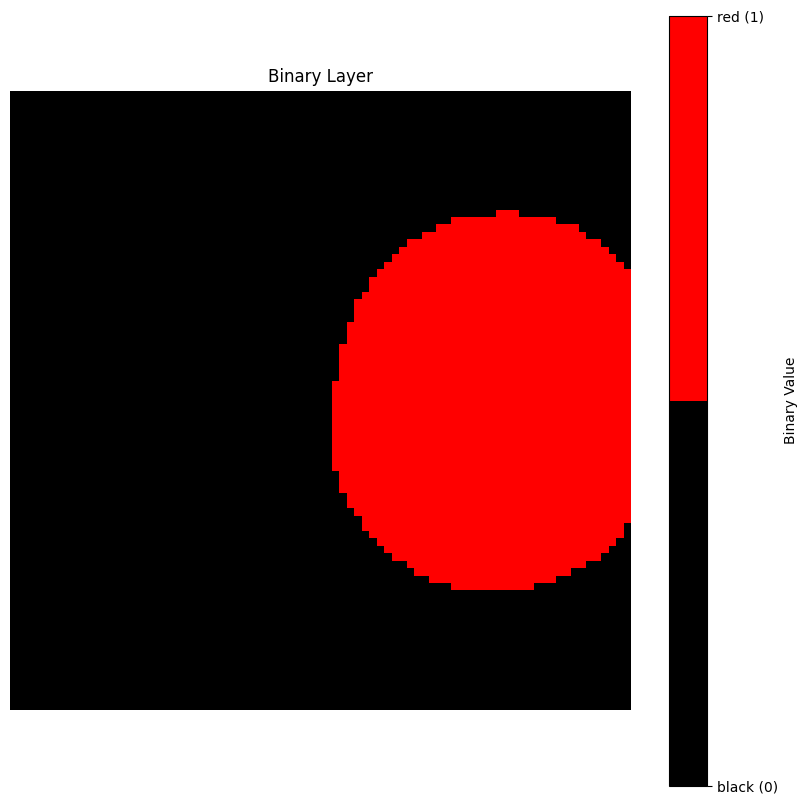

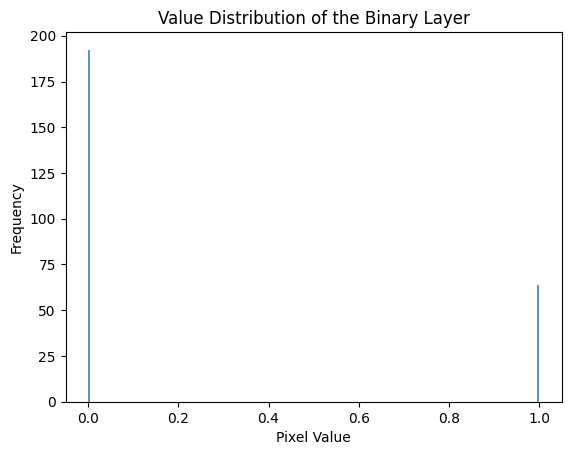

In [233]:
# Try example of convert firepoints to raster data
example_tif_file_name='438-2021-05-nicfi.tif'
fire_layer,meta=create_binary_raster(f"{tif_folder_path}\{example_tif_file_name}",J1V_shapefile_path,verbos=True)
show_binary_layer(fire_layer)
# print the meta data


show_value_distribution(fire_layer)
layer_name=f"{example_tif_file_name.split('.')[0]}-l.tif"
save_layer_as_tif(fire_layer,meta,layer_name)


In [ ]:
## Perform the data convert 


### Method 1: Tabluar 
- Combine the original tif file and the binary fire label tif file to extract the tabular data
- all the data will be saved in the csv file


- Table head include:
    - ImageIndex: the index of the tif file
    - Date: the date of the tif file
    - PixelIndex: the index of the pixel
    - Latitude: the latitude of the pixel
    - Longitude: the longitude of the pixel
    - Band1-4: the value of the band 1-4 in the tif file
    - Fire_binary: the binary of the fire label

- Example of the table head:


| ImageIndex | Date | PixelIndex | Latitude | Longitude | Band1 | Band2 | Band3 | Band4 | Fire_binary |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| int      | str      | int      | float    | float    | float  | float  | float  | float  | int      |


In [18]:
tif_folder_path_mac='tif'
tif_label_folder_path_mac='tif_label'
example_tif_file_name='438-2021-05-nicfi.tif'
example_tif_label_name='438-2021-05-nicfi-l.tif'
csvfile_name="example.csv"

csvfile_path_mac="csv"





In [19]:
import rasterio
import pandas as pd
import numpy as np
import os





# Function to extract band values and construct a DataFrame with pixel indices and geographic info
def extract_bands_with_index_and_geo_info(tif1_path, tif2_path,validate=False):
    # Parse file names to extract index and date information
    def parse_filename(filename):
        basename = os.path.basename(filename)
        parts = basename.split('-')
        index, date = parts[0], '-'.join(parts[1:3])
        return index, date
    
    # Open the first GeoTIFF file and extract its bands and geographic info
    with rasterio.open(tif1_path) as tif1:
        # Assume tif1 has 4 bands
        bands_tif1 = [tif1.read(i + 1).flatten() for i in range(4)]
        
        # Generate the latitude and longitude for each pixel
        coords = [tif1.transform * (x, y) for y in range(tif1.height) for x in range(tif1.width)]
        longitudes, latitudes = zip(*coords)  # Unzip into separate lists
        
        # Generate a pixel index from left to right, top to bottom
        pixel_indices = range(1, tif1.width * tif1.height + 1)
    
    # Open the second GeoTIFF file and extract its single band
    with rasterio.open(tif2_path) as tif2:
        # Assume tif2 has 1 band, and it matches tif1's dimensions
        band_tif2 = tif2.read(1).flatten()
    
    # Extract metadata from filenames
    tif1_index, tif1_date = parse_filename(tif1_path)
    
    # Create DataFrame with extracted data
    df = pd.DataFrame({
        'ImageIndex': tif1_index,
        'Date': tif1_date,
        'PixelIndex': pixel_indices,
        'Latitude': latitudes,
        'Longitude': longitudes,
        'Band1': bands_tif1[0],
        'Band2': bands_tif1[1],
        'Band3': bands_tif1[2],
        'Band4': bands_tif1[3],
        'Fire_binary': band_tif2
    })

    if validate:
        # percentage of the fire in the tif file
        fire_percentage=np.count_nonzero(band_tif2)/len(band_tif2)
        print(f'The fire percentage in the tif file is {fire_percentage*100:.2f}%')
        # percentage of the fire in df's fire_binary column
        fire_binary_percentage=np.count_nonzero(df['Fire_binary'])/len(df['Fire_binary'])
        print(f'The fire percentage in df\'s fire_binary column is {fire_binary_percentage*100:.2f}%')

        # count of rows in df
        print(f'The number of rows in df is {len(df)}')
        # count of pixels in tif1
        print(f'The number of pixels in tif1 is {tif1.width*tif1.height}')
        # size of tif1 and tif2 , 
    
    return df


def save_table_as_csv(df,file_name):
    file_path=os.path.join(csvfile_path_mac,file_name)
    df.to_csv(file_path,index=False)
    print(f'The table is saved to {file_path}')


In [21]:
#example running ,
df = extract_bands_with_index_and_geo_info(f'{tif_folder_path_mac}/{example_tif_file_name}',f'{tif_label_folder_path_mac}/{example_tif_label_name}',validate=True)
save_table_as_csv(df,csvfile_name)


The fire percentage in the tif file is 24.85%
The fire percentage in df's fire_binary column is 24.85%
The number of rows in df is 6889
The number of pixels in tif1 is 6889
The table is saved to csv/example.csv


### Correlation Analysis

In [ ]:
# anaylsis the correlation between the band value and the fire binary



#### Tabular Model Training